# Assignment — Generative Graph Models

In [1]:
from zlib import adler32
from scipy.stats import ks_2samp
import networkx as nx
import requests
import scipy.stats as st
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
from tqdm.notebook import trange, tqdm
import numpy as np

### Task 1. Erdos-Renyi model (0 points)

Implement Erdos Renyi model (random graph) — each pair of $n$ nodes are connected with some fixed probability $p$.

In [2]:
def erdos_renyi_graph(n, p):
    G = nx.Graph()
    nodes = np.arange(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(random_edges(nodes, p))
    return G

Write a function `random_edges` with parameters: `nodes` — np.array of nodes, for example [1, 2, 3, 4, ...] and `p` — probability of connection. The function returns np.array with tuples of the form [(1, 2), (2, 4), ...], where 1-2, 2-4 are edges that should be added in the graph.

*Hint: To speed up the generation, look at ALG.1 in the article [Efficient generation of large random networks](http://vlado.fmf.uni-lj.si/pub/networks/doc/ms/rndgen.pdf).*

In [3]:
def random_edges(nodes, p):
    ### BEGIN SOLUTION

    # Option 1: efficient approach
    lp = np.log(1.0 - p)
    edges = []
    n = len(nodes)
    w = -1
    v = 1
    while v < n:
        lr = np.log(1.0 - np.random.random())
        w = w + 1 + int(lr/lp)
        while w >= v and v < n:
            w = w - v
            v = v + 1
        if v < n:
            edges.append((nodes[v-1], nodes[w-1]))
    return np.array(edges)

    # Option 2: naive approach
    edges = []
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            n_i, n_j = nodes[i], nodes[j]
            if np.random.random() < p:
                edges.append((nodes[i], nodes[j]))
    return np.array(edges)

    ### END SOLUTION

In [4]:
'''Check the Erdos-Renyi random graph generation'''
assert len(erdos_renyi_graph(100, 0.1).edges) > 0
n = 100
p = 0.4
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma
n = 1000
p = 0.01
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma
n = 300
p = 0.9
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma

Let us draw a couple of generated graphs

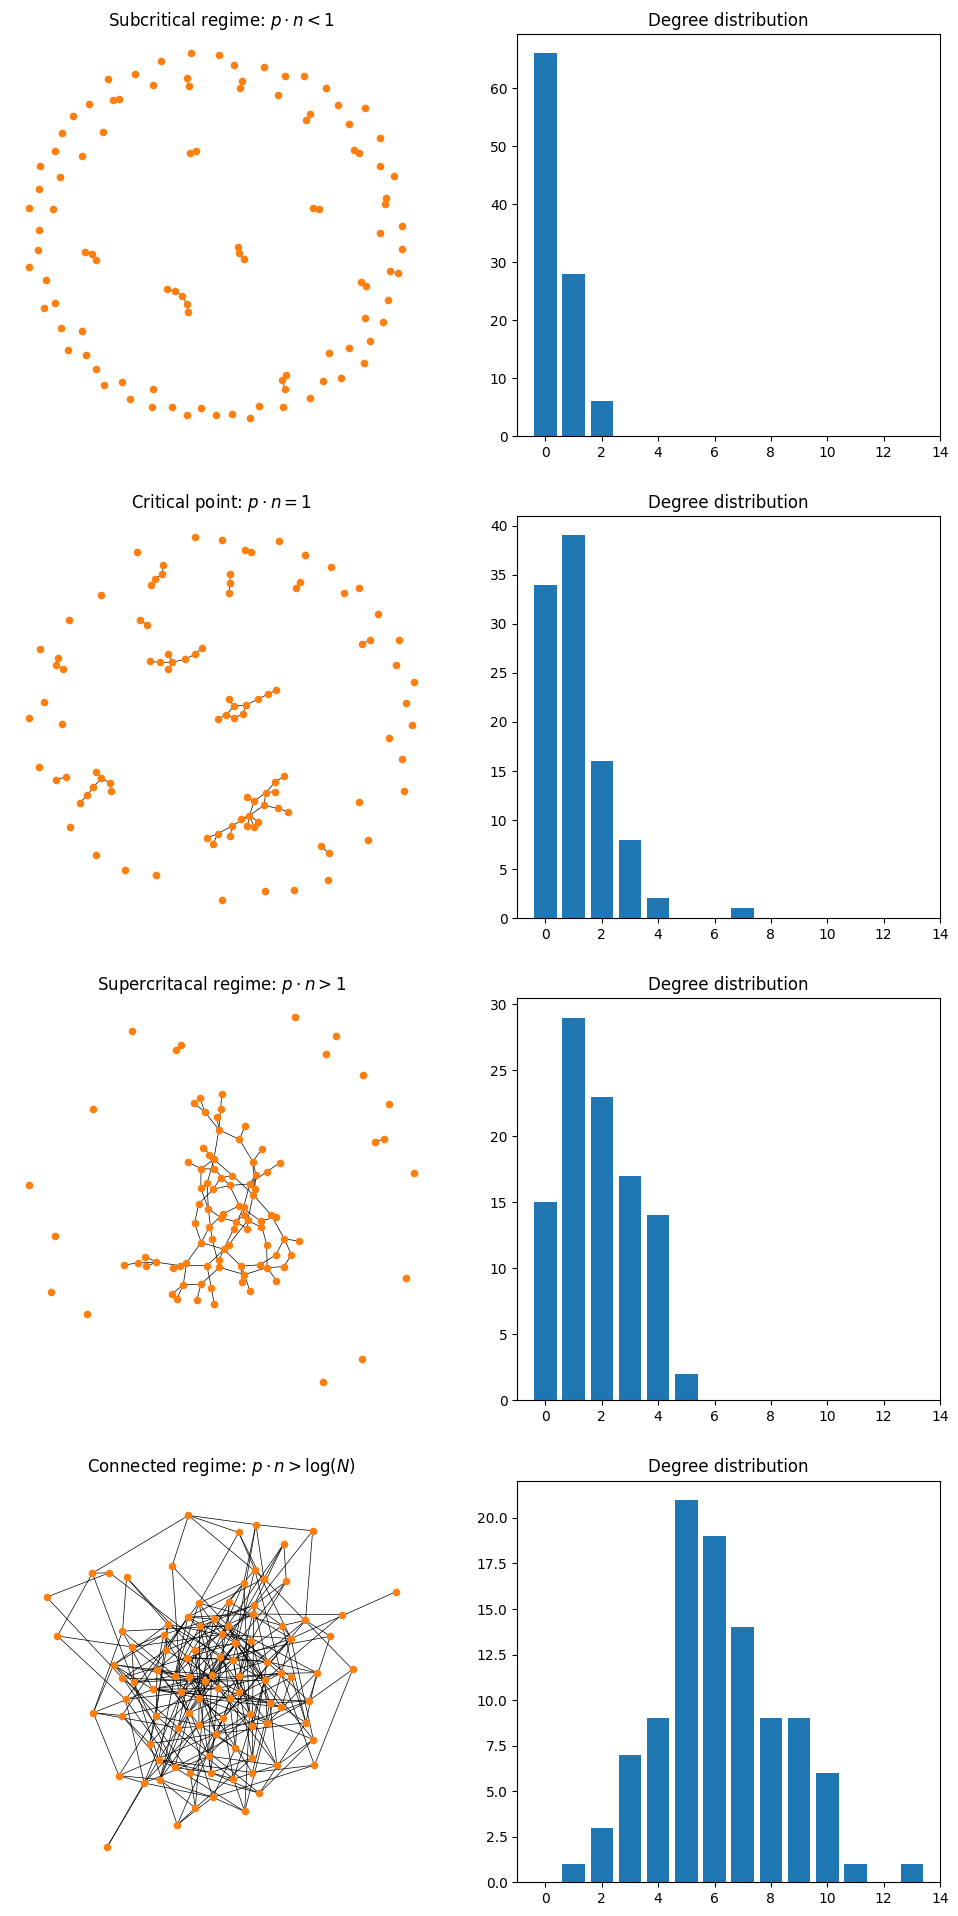

In [5]:
n = 100
cases = [('Subcritical regime: $p \cdot n < 1$', n, 0.5/n),
         ('Critical point: $p \cdot n = 1$', n, 1/n),
         ('Supercritacal regime: $p \cdot n > 1$', n, 2/n),
         ('Connected regime: $p \cdot n > \log(N)$', n, 6.5/n)]
plt.figure(figsize=(12, 6 * 4))
i = 1
for regime, n, p in cases:
    plt.subplot(4, 2, i)
    G = erdos_renyi_graph(n, p)
    nx.draw(
        G,
        with_labels=False,
        node_size=20,
        width=0.5,
        node_color='tab:orange')
    plt.title(regime)
    i += 1
    plt.subplot(4, 2, i)
    degree_seq = [degree for (node, degree) in G.degree]
    bins, freq = np.unique(degree_seq, return_counts=True)
    plt.bar(bins, freq)
    plt.xlim((-1, 14))
    plt.title('Degree distribution')
    i += 1

### Task 2. Fitting parameters of Erdos-Renyi model (1 points)

In the Erdos-Renyi model, we can estimate a degree distribution using the binomial distribution. The binomial distribution $B(n, p)$ converges to the Poisson $\text{Pois}(\lambda)$ when the number of samples $n$ tends to infinity with the fixed product $np = \lambda$.

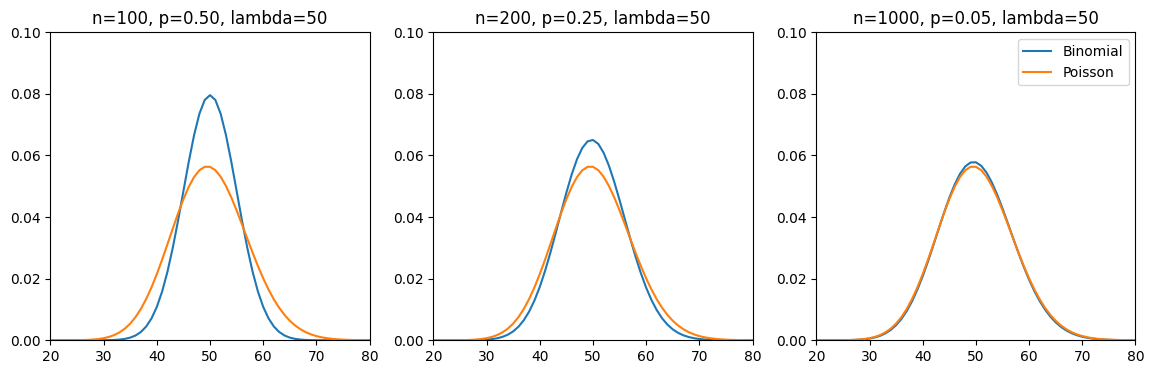

In [6]:
plt.figure(figsize=[14, 4])
for i, [n, mean] in enumerate([[100, 50], [200, 50], [1000, 50]]):
    plt.subplot(1, 3, i+1)
    plt.plot(st.binom(n, mean / n).pmf(np.arange(100)),
             label="Binomial")
    plt.plot(st.poisson(mean).pmf(np.arange(100)),
             label="Poisson")
    plt.xlim(20, 80)
    plt.ylim(0, 0.1)
    plt.title('n={}, p={:.2f}, lambda={}'.format(n, mean / n, mean))
plt.legend(loc='upper right');

In this task we will estimate properties of Binomial and Poisson distributions and compare in what cases it is better to use Binomial.

Write a function `estimate_binomial` that takes a random graph and returns binomial parameters `n` and `p`.

In [7]:
def estimate_binomial(G):
    # YOUR CODE HERE
    n = len(G.nodes())
    m = len(G.edges())
    p = 2 * m / (n * (n - 1))
    return n, p

In [8]:
G = erdos_renyi_graph(100, 0.5)
n, p = estimate_binomial(G)
assert abs(p - 0.5) <= 0.05
assert n == 100

Write a function `estimate_poisson` that takes a random graph and returns the Poisson parameter $\lambda$ (here denoted as `m`).

In [9]:
def estimate_poisson(G):
    # YOUR CODE HERE
    n = len(G.nodes())
    E = len(G.edges())
    m = 2 * E / (n-1)
    return m

In [10]:
G = erdos_renyi_graph(1000, 0.05)
m = estimate_poisson(G)
assert abs(m - 50) <= 1

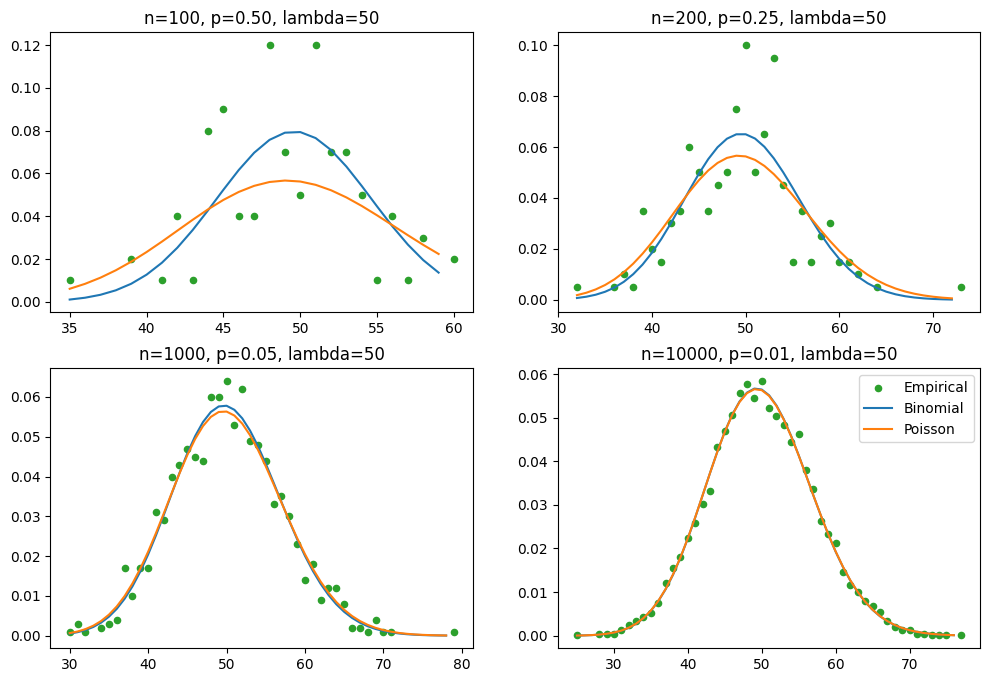

In [11]:
plt.figure(figsize=[12, 8])
for i, [n, p] in enumerate([[100, 0.5], [200, 0.25], [1000, 0.05], [10000, 0.005]]):
    plt.subplot(2, 2, i+1)
    G = erdos_renyi_graph(n, p)
    degree_density = np.array(nx.degree_histogram(G)) / n
    idx = np.argwhere(degree_density > 0)
    plt.scatter(idx, degree_density[idx], label="Empirical", c='tab:green', s=20)
    degrees = dict(G.degree).values()
    k_space = np.arange(min(degrees), max(degrees))
    plt.plot(k_space, st.binom(*estimate_binomial(G)).pmf(k_space), label="Binomial")
    plt.plot(k_space, st.poisson(estimate_poisson(G)).pmf(k_space), label="Poisson")
    plt.title(f'n={n}, p={p:.2f}, lambda={n*p:.0f}')
plt.legend()
plt.show()

### Task 3. Degree distribution of random vs real networks (1 points)

In [12]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/wiki_vote.txt'
open('wiki_vote.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/facebook_combined.txt'
open('facebook_combined.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/collaboration_network_of_arxiv_general_relativity_category.txt'
open('collaboration_network_of_arxiv_general_relativity_category.txt', 'wb').write(requests.get(url).content);


Let us compare degree distributions of real and random networks and decide whether they are close or not.

Write a function `random_from_real` that takes a graph and returns a random network that has the same average node degree and the same number of nodes as a given network.

In [13]:
def random_from_real(graph):
    n = len(graph.nodes())
    avg_degree = np.mean([d for n, d in graph.degree()])
    p = avg_degree / (n - 1)
    random_graph = nx.erdos_renyi_graph(n, p)
    return random_graph

In [14]:
for file in ['wiki_vote.txt',
             'collaboration_network_of_arxiv_general_relativity_category.txt',
             'facebook_combined.txt']:
    real_net = nx.read_edgelist(file)
    random_net = random_from_real(real_net)
    av_degree_random = np.mean(list(dict(random_net.degree).values()))
    av_degree_real = np.mean(list(dict(real_net.degree).values()))
    assert len(random_net) == len(real_net)
    assert np.abs(av_degree_random - av_degree_real) < 1

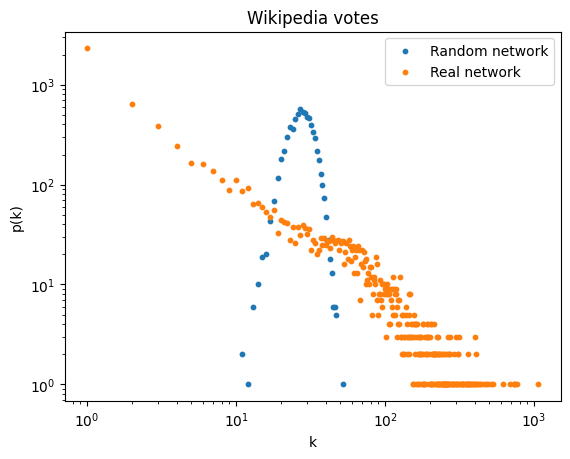

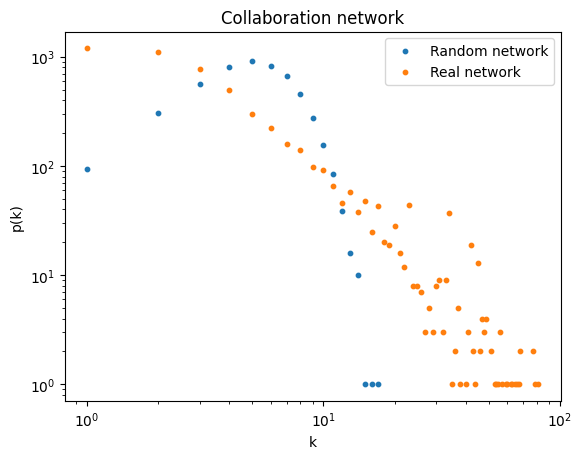

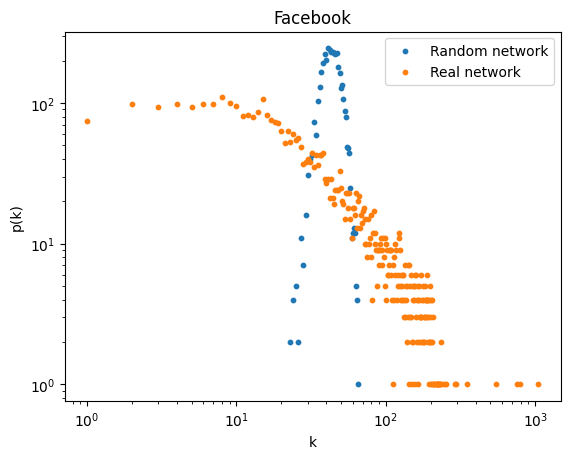

In [15]:
cases = [['Wikipedia votes', 'wiki_vote.txt'],
         ['Collaboration network', 'collaboration_network_of_arxiv_general_relativity_category.txt'],
         ['Facebook', 'facebook_combined.txt']]
for title, file in cases:
    real_net = nx.read_edgelist(file)
    random_net = random_from_real(real_net)
    degree_hist = np.array(nx.degree_histogram(random_net))
    idx = np.argwhere(degree_hist > 0)
    plt.scatter(idx, degree_hist[idx], s=10, label='Random network')
    degree_hist = np.array(nx.degree_histogram(real_net))
    idx = np.argwhere(degree_hist > 0)
    plt.scatter(idx, degree_hist[idx], s=10, label='Real network')
    plt.legend()
    plt.xlabel('k')
    plt.ylabel('p(k)')
    plt.title(title)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

### Task 4. Giant component in random graphs (0 points)

Let us see how the size of small components (small — not giant) depends on the probability near the critical point: $p =1/n$.

Write a function `small_component_size` with parameters `n` — number of nodes, `probabilities` — np.array of probabilities. The function generates a random graph for each probability and returns np.array of average sizes of small components.

*Hint: to find nodes in components, use `nx.connected_components(graph)`*

In [16]:
def small_component_size(n, probabilities):
    ### BEGIN SOLUTION
    res = []
    for p in probabilities:
        graph = erdos_renyi_graph(n, p)
        len_cc = list(map(len, sorted(nx.connected_components(graph), key=len)[:-1]))
        res.append(np.mean(len_cc))
    return np.array(res)
    ### END SOLUTION

In [17]:
n = 1000
p_space = np.linspace(0.01/n, 2.5/n, 50)
sizes = []
for _ in range(5):
    size = small_component_size(n, p_space)
    assert size.shape == (50,)
    sizes.append(size)

av_sizes = np.mean(sizes, axis=0)
assert av_sizes[0] < av_sizes[np.argmin(np.abs(p_space*n - 1))]
assert av_sizes[49] < av_sizes[np.argmin(np.abs(p_space*n - 1))]

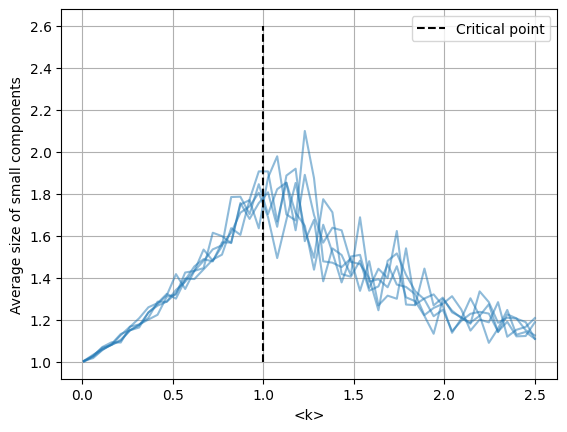

In [18]:
for i in range(5):
    plt.plot(p_space*n, sizes[i], c='tab:blue', alpha=0.5)
plt.plot([1, 1], [1, 2.6], 'k--', label='Critical point')
plt.xlabel('<k>')
plt.ylabel('Average size of small components')
plt.legend()
plt.grid()
plt.show()

Also let us see how the size of a giant component depends on the probability near the critical point.

Write a function `giant_component_size` with parameters `n` — number of nodes, `probabilities` — np.array of probabilities. The function generates a random graph for each probability and returns np.array of sizes of a giant component.

*Hint: to find nodes in a ginat component, use `max(nx.connected_components(graph), key=len)`*

In [19]:
def giant_component_size(n, probabilities):
    ### BEGIN SOLUTION
    res = []
    for p in probabilities:
        graph = erdos_renyi_graph(n, p)
        giant_nodes = max(nx.connected_components(graph), key=len)
        res.append(len(giant_nodes))
    return np.array(res)
    ### END SOLUTION

In [20]:
n = 1000
p_space = np.linspace(0.01/n, 2.5/n, 50)
sizes = []
for _ in range(5):
    size = giant_component_size(n, p_space)
    assert size.shape == (50,)
    sizes.append(size)

av_sizes = np.mean(sizes, axis=0)
assert av_sizes[0] < 20
assert 20 < av_sizes[np.argmin(np.abs(p_space*n - 1))] < 150
assert 700 < av_sizes[np.argmin(np.abs(p_space*n - 2))] < 900

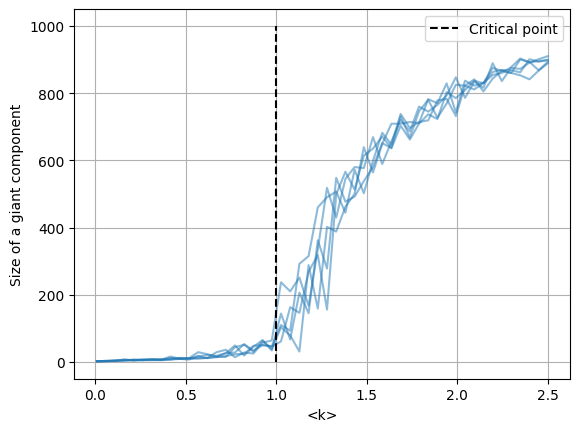

In [21]:
for i in range(5):
    plt.plot(p_space*n, sizes[i], c='tab:blue', alpha=0.5)
plt.plot([1, 1], [0, 1000], 'k--', label='Critical point')
plt.xlabel('<k>')
plt.ylabel('Size of a giant component')
plt.legend()
plt.grid()
plt.show()

### Task 5. Clustering coefficients of random vs real networks (1 points)

Clustering coefficient of a node $C_i$ contains information about relationship between nearest neighbors.  $C_i = 0$ means that there is no links between neighbors and $C_i = 1$ means that there are all possible links between them. Clustering coefficient of an Erdos-Renyi random graph is equal to the probability $p$ and does not dependent of a node and its degree:

$$C_i = \langle C \rangle = \frac{\langle k \rangle}{n} = p $$

Let us check it on generated data.

Write a function `node_degree_clustering` with parameters `n, p` — number of nodes and probability. The function generates Erdos-Renyi random graph and returns a tuple with two np.arrays: degrees and clustering coefficients. Ordering of elements should coincide: the first degree and first clustering coefficient are related to the first node and so on.

*Hint: to calculate clustering coefficients, use `nx.clustering(graph)`*

In [22]:
def node_degree_clustering(n, p):
    # YOUR CODE HERE
    graph = erdos_renyi_graph(n, p)
    degrees = np.array([deg for node, deg in graph.degree()])
    clustering_coeffs = np.array([nx.clustering(graph, node) for node in graph.nodes()])
    return degrees, clustering_coeffs

In [23]:
p = 0.9
n = 100
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()
p = 0.1
n = 1000
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()
p = 0.01
n = 3000
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()

Let us draw the dependency between node degree and clustering coefficient

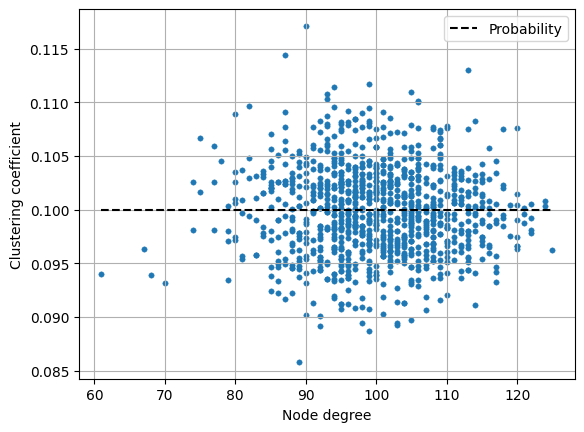

In [24]:
p = 0.1
n = 1000
degree, clustering = node_degree_clustering(n, p)
plt.scatter(degree, clustering, s=15, linewidths=0.3)
plt.plot([degree.min(), degree.max()], [p, p], 'k--', label='Probability')
plt.xlabel('Node degree')
plt.ylabel('Clustering coefficient')
plt.legend()
plt.grid()
plt.show()

Let us look at the dependency of a some real social network.

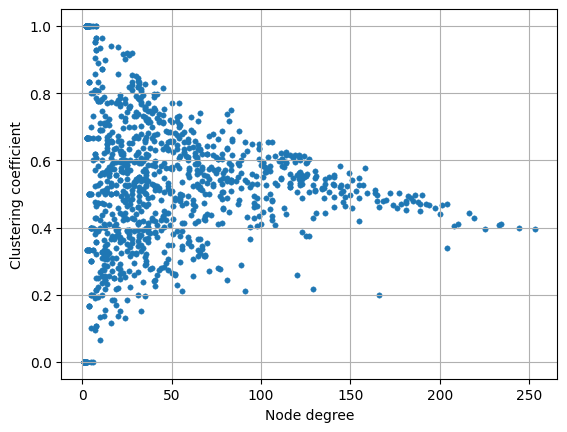

In [25]:
degree = np.loadtxt(
    'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/real_net_degree.txt'
)
clustering = np.loadtxt(
    'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/real_net_clustering.txt'
)
plt.scatter(degree, clustering, s=15, linewidths=0.3)
plt.xlabel('Node degree')
plt.ylabel('Clustering coefficient')
plt.grid()
plt.show()

We can see that the average clustering coefficient slightly decreases in high degrees.

### Task 6. Watts-Strogatz model (3 points)

Implement Watts-Strogatz model (small-world model) — rewire an edge with probability `p` in a ring lattice with `n` nodes and `k` degree.

In [26]:
def watts_strogatz_graph(n, k, p):
    G = ring_lattice(n, k)
    for node in tqdm(G.nodes):
        rewire(G, node, k, p)
    return G

Write a function `ring_lattice` that returns a regular ring lattice with `n` nodes (0, 1, 2, ..., n-1) and `k` node degree. In a case of an odd node degree, it round it to the nearest smaller even number.

In [27]:
def ring_lattice(n, k):
    # YOUR CODE HERE
    if k % 2 != 0:
        k -= 1
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(1, k // 2 + 1):
            G.add_edge(i, (i + j) % n)
            G.add_edge(i, (i - j) % n)

    return G

In [28]:
assert nx.degree_histogram(ring_lattice(10, 2))[2] == 10
assert nx.degree_histogram(ring_lattice(10, 3))[2] == 10
assert nx.degree_histogram(ring_lattice(10, 4))[4] == 10

Write a function `rewire` that takes in input a ring lattice `G`, a `node`, a model parameter `k` and probability `p`. For every right hand side neighbor $i$, the function rewires an edge (`node`, $i$) into a random edge (`node`, $j$) with probability `p` where $i \neq j \neq $ `node`.

*Hints:*
* *Why do we only rewire right hand side edges? We want to guarantee that only untouched in previous iterations edges will be rewound. Look at the picture — we could not move the red edges in previous iterations.*

![](https://raw.githubusercontent.com/netspractice/network-science/main/images/watts_strogatz_how_to_rewire.png)

* *To speed up the generation, do not filter nodes to random selection. If a selected node produces an existing edge or a loop, just skip it.*

In [29]:
def rewire(G, node, k, p):
    # YOUR CODE HERE
    right_neighbors = list(G.neighbors(node))[:k//2]

    for neighbor in right_neighbors:
        if random.random() < p:
            while True:
                new_node = random.choice(list(G.nodes))
                if new_node != node and new_node not in right_neighbors:
                    if not G.has_edge(node, new_node):
                        G.remove_edge(node, neighbor)
                        G.add_edge(node, new_node)
                        break

    return G

In [30]:
cases = [[50, 8, 0.1],
         [1000, 10, 0.01],
         [1000, 10, 0.5],
         [1000, 10, 0.99]]
for n, k, p in cases:
    G = watts_strogatz_graph(n, k, p)
    assert nx.number_of_nodes(G) == n
    assert nx.number_of_edges(G) == int(k / 2 * n)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.watts_strogatz_graph(n, k, p, 1)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Let us draw a small-world graph in some steps of the algorithm

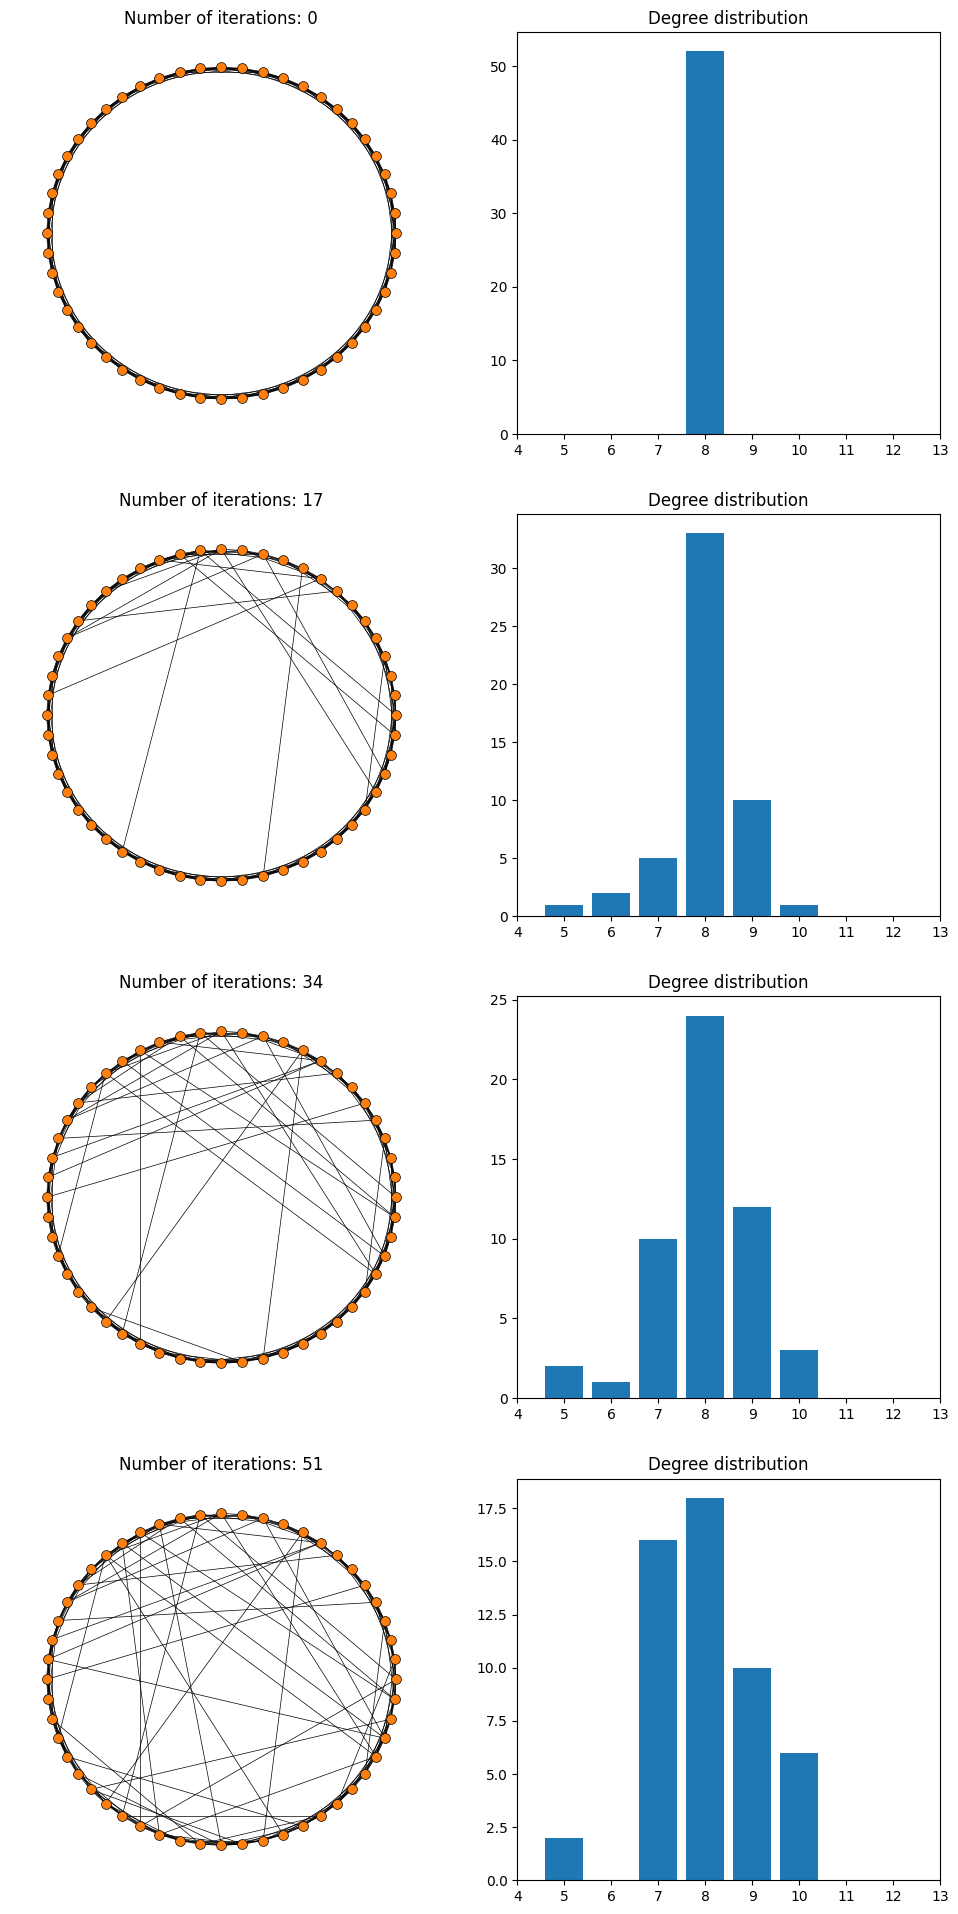

In [31]:
n, k, p = 52, 8, 0.2
G = ring_lattice(n, k)
plt.figure(figsize=(12, 6 * 4))
i = 1
for node in G.nodes:
    if node in np.arange(0, n+1, int(n/3)):
        plt.subplot(4, 2, i)
        plt.title('Number of iterations: {}'.format(node))
        nx.draw_circular(
            G,
            node_size=50,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        i += 1
        plt.subplot(4, 2, i)
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.bar(bins, freq)
        plt.xlim((4, 13))
        plt.title('Degree distribution')
        i += 1
    rewire(G, node, k, p)

### Task 7. Average path length in Watts-Strogatz (0 points)

Let us check that the average path length tends to theoretical value during building the small-world model.

$$\langle L \rangle = \begin{cases}
N/2k, \text{ if } p \to 0 \\
\log(N)/\log(k), \text{ if } p \to 1
\end{cases}$$

So that we have a lower and upper limits of path lengths for $0 < p < 1$.

Write a function `smallworld_path_len` with Watts-Strogatz model parameters `n, k, p` that returns np.array of average path lengths in each step (node). The length of the array is `n`.

*Hint: to calculate the average shortest path length, use `nx.average_shortest_path_length`*

In [32]:
def smallworld_path_len(n, k, p):
    ### BEGIN SOLUTION
    lengths = []
    G = ring_lattice(n, k)
    for i, node in enumerate(G.nodes):
        rewire(G, node, k, p)
        lengths.append(nx.average_shortest_path_length(G))
    return np.array(lengths)
    ### END SOLUTION

In [33]:
n, k, p = 101, 10, 0.05
lengths = smallworld_path_len(n, k, p)
step_space = np.log(np.arange(1, len(lengths) + 1))
X = np.stack([step_space, np.ones(lengths.shape[0])], axis=1)
assert lengths.shape[0] == n
assert 0.1 < -(np.linalg.pinv(X) @ np.log(lengths))[0] < 0.25

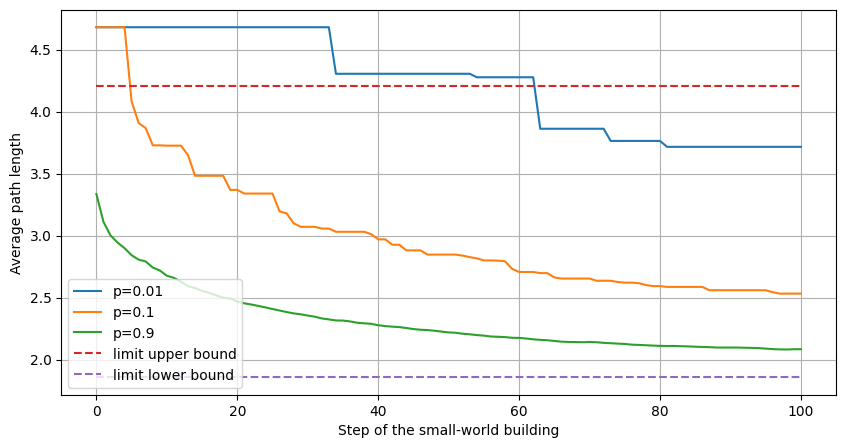

In [34]:
plt.figure(figsize=(10, 5))

n, k, p = 101, 12, 0.01
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

n, k, p = 101, 12, 0.1
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

n, k, p = 101, 12, 0.9
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

plt.xlabel('Step of the small-world building')
plt.ylabel('Average path length')
plt.grid()
plt.plot([0, 100], [n / 2 / k, n / 2 / k], '--',
         label='limit upper bound')
plt.plot([0, 100], [np.log(n) / np.log(k), np.log(n) / np.log(k)], '--',
         label='limit lower bound')
plt.legend(loc='lower left')
plt.show()

### Task 8. Barabasi-Albert model (2 points)

Implement Barabasi-Albert model (preferential attachment model) – a growth process where each new node connects to `m` existing nodes. The higher node degree, the higher probability of the connection. The final number of nodes is `n`.

You start from a star graph with `m + 1` nodes. In each step you create `m` edges between a new node and existing nodes. The probability of connection to the node $i$ is
$$p(i) = \frac{k_i}{\sum k}$$

Write a function `attach` that attaches a `node` to a graph `G` through `m` edges.

*Hint: Create a list with repeated nodes from a list of edges. For example, $[(1, 2), (2, 3), (2, 4)] \to [1, 2, 2, 3, 2, 4]$. Uniformly select nodes one-by-one. Apply `random.choice` instead of `np.random.choice` to speed up the generation.*

In [35]:
'''Do not touch the cell'''
def barabasi_albert_graph(n, m):
    G = nx.star_graph(m)
    for i in trange(1, n - m):
        attach(m + i, G, m)
    return G

In [36]:
def attach(node, G, m):
    # YOUR CODE HERE
    degree_list = []
    for u, v in G.edges:
        degree_list.append(u)
        degree_list.append(v)
    targets = set()
    while len(targets) < m:
        new_target = random.choice(degree_list)
        targets.add(new_target)
    for target in targets:
        G.add_edge(node, target)
    return G

In [37]:
G = nx.star_graph(3)
attach(4, G, 3)
assert nx.number_of_edges(G) == 6

cases = [[10, 3],
         [1000, 3],
         [1000, 20]]
for n, m in cases:
    G = barabasi_albert_graph(n, m)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.barabasi_albert_graph(n, m)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/996 [00:00<?, ?it/s]

  0%|          | 0/979 [00:00<?, ?it/s]

Let us see what the growth process looks like

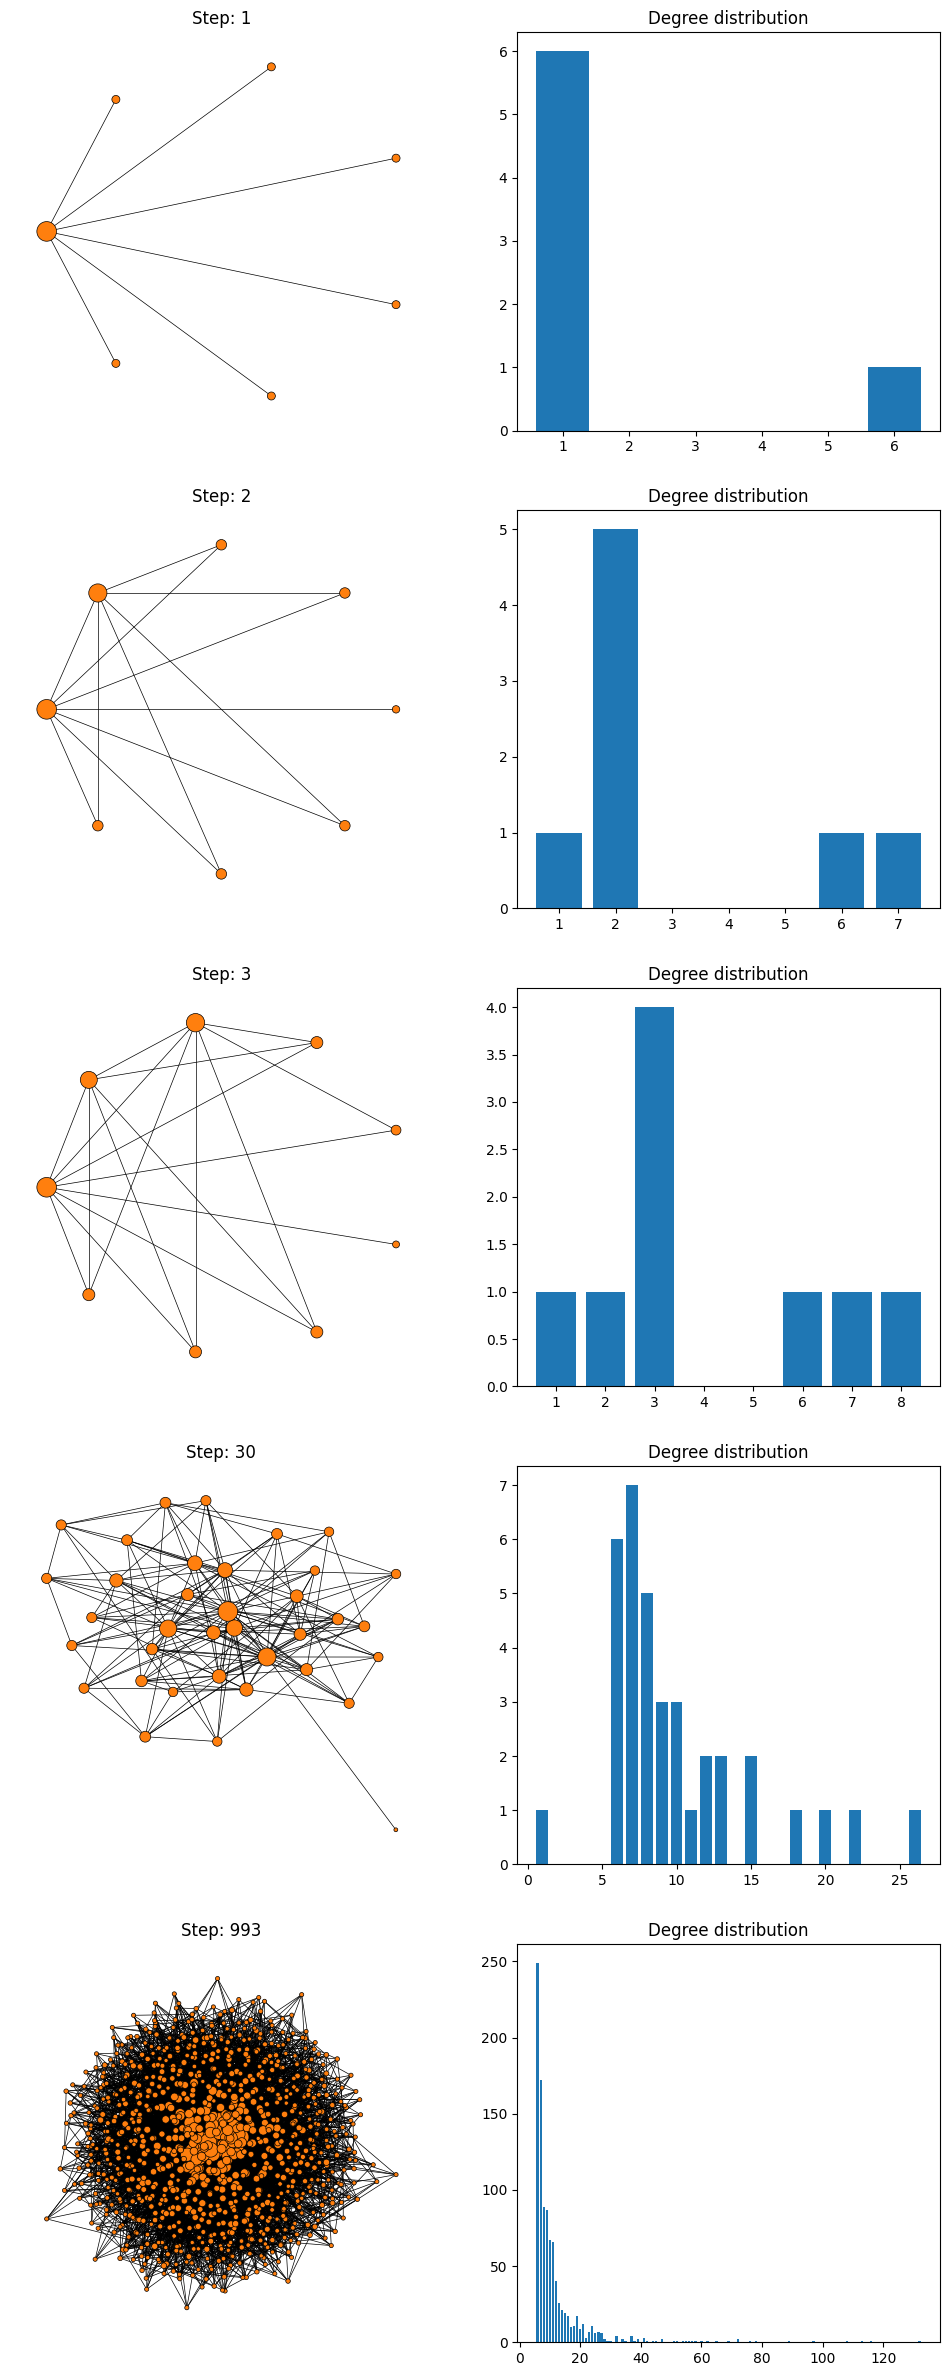

In [38]:
n, m = 1000, 6
G = nx.star_graph(m)
plt.figure(figsize=(12, 6 * 5))
j = 1
for i in range(1, n - m):
    if i in [1, 2, 3, 30, n-m-1]:
        plt.subplot(5, 2, j)
        j += 1
        sizes = np.array(list(nx.degree_centrality(G).values()))
        sizes = sizes / max(sizes) * 200
        if i <= 3:
            pos = nx.layout.shell_layout(G)
        else:
            pos = nx.layout.spring_layout(G)
        nx.draw(
            G,
            pos=pos,
            with_labels=False,
            node_size=sizes,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        plt.title('Step: {}'.format(i))
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.subplot(5, 2, j)
        j += 1
        plt.bar(bins, freq)
        plt.title('Degree distribution')
    attach(m + i, G, m)

### Task 9. Degree distribution in Barabasi-Albert model (0 points)

Barabasi-Albert graph has a degree distribution of the form

$$P(k) = \frac{2m^2}{k^3}$$

That is Power law with $\alpha = 3$ and $k_\min = m$.

Check this fact by an experiment — generate a set of Barabasi-Albert graphs and estimate parameters of Power law using MLE

$$\alpha = 1 + n \left[\sum_i \log \frac{k_i}{k_\min} \right]^{-1}$$

where the $k_\min$ is selected by minimal Kolmogorov-Smirnov distance between observed and theoretical distributions.

First, write a function `power_law_cdf` that takes an argument and parameters of the Power law distribution and returns the CDF.

In [39]:
def power_law_cdf(k, alpha=3.5, k_min=1):
    ### BEGIN SOLUTION
    return 1 - (k / k_min) ** (1 - alpha)
    ### END SOLUTION

In [40]:
assert power_law_cdf(2, 2, 1) == 0.5
assert power_law_cdf(10, 2, 1) == 0.9

Next, write a function `mle_power_law_params` that takes a degree sequence and returns a tuple: the best $\alpha$, w.r.t. MLE, the best $k_\min$ w.r.t. Kolmogorov-Smirnov distance

_Hint: use `scipy.stats.kstest` where a theoretical CDF is a `power_law_cdf` function and `args=(alpha, k_min)`_

In [41]:
def mle_power_law_params(degree_sequence):
    ### BEGIN SOLUTION
    from scipy.stats import kstest
    best_alpha, best_x_min = None, None
    min_ks_dist = np.inf
    for x_min in np.arange(degree_sequence.min(), degree_sequence.max()):
        _degree_sequence = degree_sequence[degree_sequence >= x_min]
        alpha = 1 + len(_degree_sequence) / np.log(_degree_sequence / x_min).sum()
        ks_dist = kstest(_degree_sequence, power_law_cdf, args=(alpha, x_min)).statistic
        if ks_dist < min_ks_dist:
            min_ks_dist, best_alpha, best_x_min = ks_dist, alpha, x_min
    return best_alpha, best_x_min
    ### END SOLUTION

In [42]:
assert mle_power_law_params(np.array([1, 2, 3]))[0] > 0
assert mle_power_law_params(np.array([1, 2, 3]))[1] > 0

Write a function `estimate_power_law` that generates Barabasi-Albert graphs with `n` nodes, from `m_min` to `m_max` connections and returns a tuple of np.arrays: $\alpha$ and $k_{\min}$ for each graph.

In [43]:
def estimate_power_law(n, m_min, m_max):
    ### BEGIN SOLUTION
    alpha_space = []
    k_min_space = []
    for m in np.arange(m_min, m_max + 1):
        G = nx.barabasi_albert_graph(n, m)
        degree_seq = np.array([degree for (node, degree) in G.degree])
        alpha, k_min = mle_power_law_params(degree_seq)
        alpha_space.append(alpha)
        k_min_space.append(k_min)
    return np.array(alpha_space), np.array(k_min_space)
    ### END SOLUTION

In [44]:
'''Check the Power law parameters'''
n, m_min, m_max = 500, 2, 20
alpha, k_min = estimate_power_law(n, m_min, m_max)
assert alpha.shape[0] == m_max - m_min + 1
assert 2 < alpha.mean() < 4
assert k_min[0] < k_min[-1]

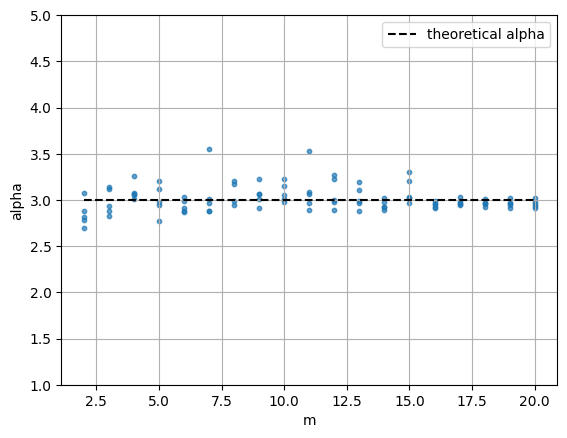

In [45]:
n, m_min, m_max = 500, 2, 20
m_space = np.arange(m_min, m_max + 1)
for _ in range(5):
    alpha, k_min = estimate_power_law(n, m_min, m_max)
    plt.scatter(m_space, alpha, alpha=0.7, c='tab:blue', s=10)
plt.plot([2, 20], [3, 3], 'k--', label='theoretical alpha')
plt.ylim((1, 5))
plt.xlabel('m')
plt.ylabel('alpha')
plt.grid()
plt.legend()
plt.show()

### Task 10. Degree dynamics in Barabasi-Albert model (2 points)

Measure the degree dynamics in Barabasi-Albert model of one of the initial nodes and of the nodes added to the network at intermediate time moments (steps of the algorithm).

Write a function `generate_degree_dynamics` that takes np.array with considered nodes, generates Barabasi-Albert graph ($n=3000$, $m=6$) and returns a np.array of the shape `(30, len(cons_nodes))` — degrees of these nodes at time moments when nodes 99, 199, 299, ..., 2999 appear. If a node does not exist yet, pass `np.nan` value.

*Hint: use the `barabasi_albert_graph` function as a template*

In [46]:
def generate_degree_dynamics(cons_nodes):
    # YOUR CODE HERE
    n, m = 3000, 6
    G = nx.star_graph(m)
    degree_dynamics = np.full((30, len(cons_nodes)), np.nan)
    step_idx = 0
    for i in trange(1, n - m):
        attach(m + i, G, m)
        if (i + m) % 100 == 99:
            for j, node in enumerate(cons_nodes):
                if node <= m + i:
                    degree_dynamics[step_idx, j] = G.degree[node]
            step_idx += 1
            if step_idx == 30:
                break
    return degree_dynamics

In [47]:
degree_dynamics = generate_degree_dynamics([99, 199, 699, 1999])
assert degree_dynamics.shape == (30, 4)
assert np.all(np.isnan(degree_dynamics[0]) == [False, True,  True,  True])
assert np.all(np.isnan(degree_dynamics[9]) == [False, False,  False,  True])
assert degree_dynamics[0, 0] < degree_dynamics[-1, 0]
assert degree_dynamics[1, 1] < degree_dynamics[-1, 1]
assert degree_dynamics[-1, 0] > degree_dynamics[-1, 3]

  0%|          | 0/2993 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2993 [00:00<?, ?it/s]

  0%|          | 0/2993 [00:00<?, ?it/s]

  0%|          | 0/2993 [00:00<?, ?it/s]

  0%|          | 0/2993 [00:00<?, ?it/s]

  0%|          | 0/2993 [00:00<?, ?it/s]

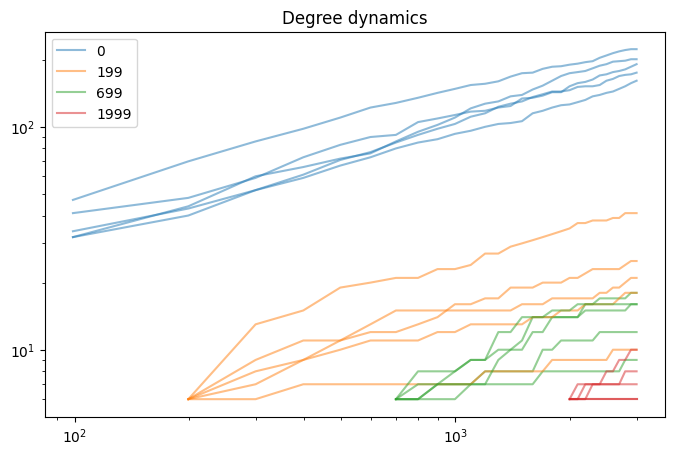

In [48]:
cons_nodes = [0, 199, 699, 1999]
colors = plt.cm.tab10.colors
plt.figure(figsize=(8, 5))
for _ in trange(5):
    degree_dynamics = generate_degree_dynamics(cons_nodes)
    time_space = np.arange(99, 3000, 100)
    for i in range(4):
        plt.plot(time_space, degree_dynamics[:, i], c=colors[i], alpha=0.5)
plt.legend(cons_nodes)
plt.title('Degree dynamics')
plt.xscale('log')
plt.yscale('log')
plt.show()